# 02. Ice motion maps from OSI-SAF sea ice motion data
Data source: https://unep-viewer.mercator-ocean.eu/product/SEAICE_GLO_SEAICE_L4_NRT_OBSERVATIONS_011_001/files?path=SEAICE_GLO_SEAICE_L4_NRT_OBSERVATIONS_011_001%2FMETNO-GLO-SEAICE_DRIFT-NORTH-L4-NRT-OBS%2F&subdataset=osisaf_obs-si_glo_phy-sitype_nrt_sh-P1D_202107

Code by MacKenzie Jewell, edited by Noel Wang. Version in the FORK

## Import packages

In [81]:
# general
import numpy as np, numpy.ma as ma
import xarray as xr
import pandas as pd

# time
from datetime import datetime, timedelta
import matplotlib.dates as mdates

# local system 
import sys  
import glob
import os

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors
import cmocean

# geo plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat

# for use in suppressing repeated warnings when mapping w/ shapely
import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

# path to own functions
sys.path.append('../Libraries_functions/')
from LIB_ASI_SIC_UniB import grab_ASI_SIC, grab_projinfo_SIC
from LIB_geo_func import *
from LIB_geo_plot import *


# OSI SAF sea ice drift
from LIB_OSI_SAF import grab_projinfo_OSISAF, grab_OSISAF_drift

# NSIDC sea ice drift
from LIB_PPdrift_NSIDC0116 import grab_projinfo_PPdrift


%load_ext autoreload
%autoreload 2
# potentially uninstall pyhdf?

#math
import math

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
main_path = '/Volumes/Seagate2/OSI_SAF_Drift/'

ds = xr.open_dataset(main_path + 'ice_drift_nh_polstere-625_multi-oi_202401131200-202401151200.nc')
ds.close

NSIDC = {}

NSIDC['time'] = ds.time.values
NSIDC['x'] = ds.xc.values
NSIDC['y'] = ds.yc.values
NSIDC['dx'] = ds.dX.values
NSIDC['dy'] = ds.dY.values
NSIDC['proj'] = grab_OSISAF_drift(ds)

#========
week = 53
month = 1
#========

print(NSIDC['time'][week])
print(NSIDC['time'][month])

TypeError: unsupported operand type(s) for -: 'int' and 'datetime.timedelta'

In [30]:
ds
ds['xc'].shape

(119,)

### OSI-SAF sea ice drift

In [14]:

# specify date to import
#============================
date = datetime(2024, 1, 14)
#============================

#takes the middle day (peep documentation)

OSISAF = grab_OSISAF_drift(date = date, 
                          main_path = '/Volumes/Seagate2/OSI_SAF_Drift/')




## Make map

In [65]:

# specify date to plot
#============================
date = datetime(2024, 1, 12)
#============================

# read daily sic data from computer files into dictionary
data = grab_ASI_SIC(date=date, 
                    main_path='/Volumes/Seagate2/asi-AMSR-SIC/n6250/', 
                    coord_file='LongitudeLatitudeGrid-n6250-Arctic.hdf', 
                    hemisphere='n', resolution='6250', version='v5.4', 
                    return_vars=['xx', 'yy', 'lon', 'lat', 'sic', 'proj', 'ds'], 
                    include_units=False, annual_folders=True, return_dict = True, quiet=True)

# create figure
#--------------
# create map figure in north polar stereographic projection
map_projection = ccrs.NorthPolarStereo(central_longitude=205)
fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(projection=map_projection))

# background color
ax.patch.set_facecolor('lightgray')

# set map extent [lon1, lon2, lat1, lat2]
ax.set_extent([150, 250, 65, 85], crs=ccrs.PlateCarree())  

# add coastlines
ax.coastlines(zorder=100)

# lat / lon lines
add_grid(ax, lats=np.arange(60,90,10), lons=np.arange(0,360,90), linewidth=1, color='gray', alpha=0.5, zorder=4)


# plot 2d sic data 
icec = ax.pcolormesh(data['xx'], data['yy'], data['sic'], 
                     cmap = cmocean.cm.ice, vmin=0, vmax=100, transform=data['proj'])

plt.colorbar(icec, label='SIC (%)', orientation='horizontal', shrink = 0.5, pad=0.025)


# label date
ax.text(0, 1, date.strftime('%Y-%B-%d'), ha='left', va='bottom', transform=ax.transAxes, clip_on=False)


# OSISAF sea ice drift
qv1 = ax.quiver(OSISAF['x'], OSISAF['y'], OSISAF['dx']/2, OSISAF['dy']/2, 
               color = 'gray', width = 0.002, headwidth=5, scale = 1000, transform = OSISAF['proj'], zorder=5)
qk = ax.quiverkey(qv1, 0.9, 0.1, 20, r'$20 \frac{km}{day}$', labelpos='E',transform=ccrs.PlateCarree(),)


# NSIDC sea ice drift
sp = 3
qv2 = ax.quiver(NSIDC['x'][::sp], NSIDC['y'][::sp], NSIDC['u'][week,:,:][::sp,::sp], NSIDC['v'][week,:,:][::sp,::sp], 
               color = 'k', width = 0.002, headwidth=5, scale = 1000*1.15741, transform = NSIDC['proj'], zorder=5)
qk = ax.quiverkey(qv2, 0.9, 0.3, 20, r'$20 \frac{cm}{s}$', labelpos='E',transform=ccrs.PlateCarree(),)


plt.show()


# save figure, if desired
# save_path = f'/Users/jewell/Desktop/map_{date.strftime("%Y-%m-%d")}.png'
# fig.savefig(save_path, dpi=300, bbox_inches = 'tight')

AssertionError: "/Volumes/Seagate2/asi-AMSR-SIC/n6250/asi-AMSR2-n6250-2024/" not an existing directory

### Create timeseries

In [83]:

# all_speeds = np.array([])
all_speeds = []
angles_list = []
all_dates = pd.date_range(start='2024-1-1', end='2024-1-30', freq='D')

x_cr = (22, 33) # bottom, top
y_cr = (83, 92) #left, right

for date in all_dates:

    OSISAF = grab_OSISAF_drift(date = date, 
                          main_path = '/Volumes/Seagate2/OSI_SAF_Drift/')
    
#figure out the cropping

    crop_dx = OSISAF['dx'][y_cr[0]:y_cr[1], x_cr[0]:x_cr[1]]/2
    crop_dy = OSISAF['dy'][y_cr[0]:y_cr[1], x_cr[0]:x_cr[1]]/2
    region_speed = np.sqrt(np.nanmean(crop_dx)**2 + np.nanmean(crop_dy)**2)
    all_speeds.append(region_speed)
    
    #angle
    angle = math.atan((np.nanmean(crop_dx))/np.nanmean(crop_dy)
             )
    angles_list.append(angle)

print(len(all_speeds))
print(angles_list)


30
[-0.8686887126843655, 0.3500002154387695, 0.6158116999803406, 0.6379867374657687, 0.5749752235436838, 0.49034553813254833, 0.6386143756882374, 0.7569733741378261, 0.6750758451003849, 0.5682017813242867, 0.5109834548625498, 0.670206376180512, 0.8086057081809872, 0.8421277488349228, 0.7589301948277232, 1.5701811103417547, -0.08982490071890693, 1.2100076344385822, 1.520606863782028, 1.4347385040136673, 1.4048483672522158, 0.8619749053137441, 0.09698861025146248, 0.40728690769704096, 0.6621651838888449, 0.5999719841915576, 1.0920941008639038, -0.049428908194720796, 0.38190779457157964, 0.40930164080459835]


** use geometry to find the average direction :)

In [37]:
x_grid, y_grid = np.meshgrid(OSISAF['x'], OSISAF['y'])

x_grid.shape
OSISAF["dx"].shape

(177, 119)

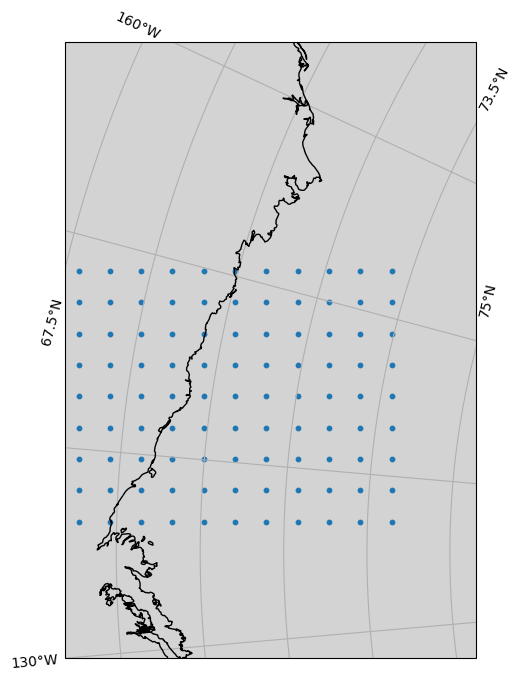

In [86]:
OSISAF.keys()
# fig2, ax2 = plt.subplots(figsize = (10, 10))

# create map figure in north polar stereographic projection
map_projection = ccrs.NorthPolarStereo(central_longitude=205)
fig2, ax2 = plt.subplots(figsize=(8,8), subplot_kw=dict(projection=OSISAF['proj']))

# background color
ax2.patch.set_facecolor('lightgray')

# set map extent [lon1, lon2, lat1, lat2]
ax2.set_extent([200, 230, 68, 74], crs=ccrs.PlateCarree()) 

ax2.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)

ax2.scatter(x_grid[y_cr[0]:y_cr[1], x_cr[0]:x_cr[1]], y_grid[y_cr[0]:y_cr[1], x_cr[0]:x_cr[1]], transform = OSISAF['proj'], s=10)

# add coastlines
ax2.coastlines(zorder=100)

In [76]:
OSISAF['proj']
print(all_speeds)
print(region_speed)

[21.34035681]
21.340356810064275


Text(0.5, 1.0, 'Sea ice drift angle 01-Jan-2024 to 30-Jan-2024 over polynya')

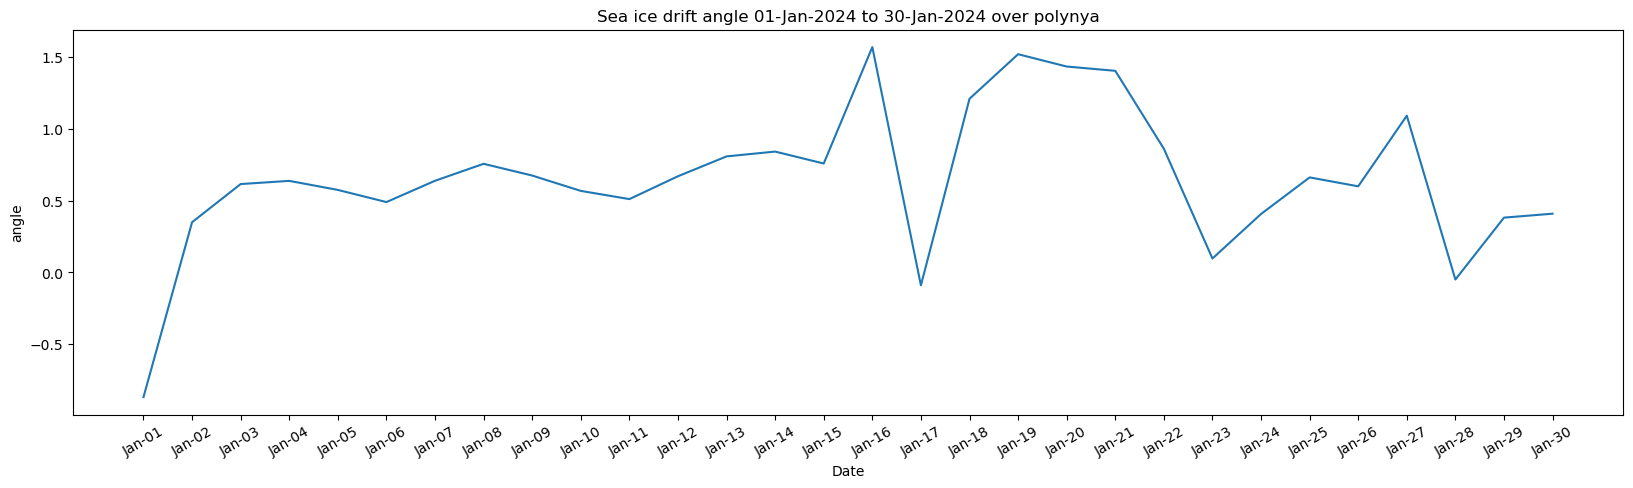

In [85]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(all_dates, angles_list)

#ax.axhline(10, c='k', linestyle='dashed')

#formatting the plot
plt.xticks(rotation=30)
plt.xticks(all_dates)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
#labels
plt.xlabel('Date')
# ax.set_ylabel('sea ice speed (km/day)')

ax.set_ylabel('angle')

plt.title(f'Sea ice drift angle {all_dates[0].strftime("%d-%b-%Y")} to {all_dates[-1].strftime("%d-%b-%Y")} over polynya')